**Clone Colab to Github**

In [ ]:
!git clone https://github.com/PlastiCode-374/ML-PlastiCode.git

Cloning into 'ML-PlastiCode'...
remote: Enumerating objects: 3, done.
remote: Counting objects: 100% (3/3), done.
remote: Total 3 (delta 0), reused 0 (delta 0), pack-reused 0
Unpacking objects: 100% (3/3), 600 bytes | 600.00 KiB/s, done.


**Menyambungkan antara google colab dengan google drive**

In [ ]:
from google.colab import drive
drive.mount('/content/drives/')

Mounted at /content/drives/


**Input Library**

In [ ]:
from __future__ import absolute_import, division, print_function, unicode_literals

try:
  # The %tensorflow_version magic only works in colab.
  %tensorflow_version 2.x
except Exception:
  pass
import numpy as np 
import math, os, sys
import itertools

import matplotlib.pyplot as plt
plt.style.use('default')
from scipy import ndimage

from skimage import measure, morphology
from skimage.io import imsave, imread
from skimage.filters import threshold_otsu
from skimage.transform import resize

import tensorflow as tf
from sklearn import svm, datasets
from sklearn.metrics import confusion_matrix
import pandas as pd

Colab only includes TensorFlow 2.x; %tensorflow_version has no effect.


In [ ]:
!ls "/content/drives/MyDrive/Capstone/data jenis plastik"
!ls "/content/drives/MyDrive/Capstone/data jenis plastik/train"

PlastiCode  train  validation
hdpe  ldpe  other  pet	pp  ps	pvc


In [ ]:
#Perintah untuk memvisualisasikan satu gambar dari data train
#image = imread("/content/drives/MyDrive/Capstone/data jenis plastik/train/hdpe/124153_10-12-2019_16-17-51.jpeg")
#plt.figure(figsize=(3,3))
#plt.imshow(image)

**Memuat Dataset Training dan Validation**

In [ ]:
from keras.preprocessing.image import ImageDataGenerator

TRAINING_DIR = "/content/drives/MyDrive/Capstone/data jenis plastik/train"
training_datagen = ImageDataGenerator(
      rescale = 1./255,
	    rotation_range=40,
      width_shift_range=0.2,
      height_shift_range=0.2,
      shear_range=0.2,
      zoom_range=0.2,
      horizontal_flip=True,
      fill_mode='nearest')

VALIDATION_DIR = "/content/drives/MyDrive/Capstone/data jenis plastik/validation"
validation_datagen = ImageDataGenerator(rescale = 1./255)

train_generator = training_datagen.flow_from_directory(
	TRAINING_DIR,
	target_size=(150,150),
	class_mode='categorical',
  batch_size=128
)

validation_generator = validation_datagen.flow_from_directory(
	VALIDATION_DIR,
	target_size=(150,150),
	class_mode='categorical',
  batch_size=128
)

Found 1581 images belonging to 7 classes.
Found 451 images belonging to 7 classes.


**Menyimpan Label**

In [ ]:
print (train_generator.class_indices)

labels_txt = '\n'.join(sorted(train_generator.class_indices.keys()))

with open('labels.txt', 'w') as f:
  f.write(labels_txt)

{'hdpe': 0, 'ldpe': 1, 'other': 2, 'pet': 3, 'pp': 4, 'ps': 5, 'pvc': 6}


In [ ]:
# Format images for the task
# Resize the images to a fixed input size and rescale the input channels to a range[-1,1]
IMG_SIZE = 160  # All images will be resized to 160x160

def format_example(image, label):
    image = tf.cast(image, tf.float32)
    image = (image/127.5) - 1
    image = tf.image.resize(image, (IMG_SIZE, IMG_SIZE))
    return image, label

**Membuat Model dari Jaringan CNN yang sudah dipelajari sebelumnya**

***Feature Extraction***
Menggunakan model pre-trained untuk ekstraksi fitur (feature extraction) : Ketika bekerja dengan dataset kecil, adalah umum untuk mengambil keuntungan dari fitur yang dipelajari oleh model yang dilatih pada dataset yang lebih besar dalam domain yang sama. Ini dilakukan dengan membuat contoh model pre-trained dan menambahkan classifier yang sepenuhnya terhubung di atas. Model pre-trained adalah "beku" dan hanya bobot pengklasifikasi yang diperbarui selama pelatihan. Dalam hal ini, basis konvolusional mengekstraksi semua fitur yang terkait dengan setiap gambar dan Anda baru saja melatih classifier yang menentukan kelas gambar mengingat set fitur yang diekstraksi.

In [ ]:
IMG_SHAPE = (224, 224, 3)
# Membuat model dasar (base model) dari pre-trained model MobileNet
base_model = tf.keras.applications.MobileNetV2(input_shape=IMG_SHAPE,
                                              include_top=False, 
                                              weights='imagenet')

9406464/9406464 [==============================] - 1s 0us/step


In [ ]:
base_model.trainable = False
base_model.summary()

Model: "mobilenetv2_1.00_224"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 224, 224, 3  0           []                               
                                )]                                                                
                                                                                                  
 Conv1 (Conv2D)                 (None, 112, 112, 32  864         ['input_1[0][0]']                
                                )                                                                 
                                                                                                  
 bn_Conv1 (BatchNormalization)  (None, 112, 112, 32  128         ['Conv1[0][0]']                  
                                )                                              

In [ ]:
import keras
from keras import backend as K
from keras.models import Sequential
from keras import layers
from keras.utils.np_utils import to_categorical

from sklearn.model_selection import train_test_split

**Pembuatan Model (Menambah Model untuk Melakukan Klasifikasi**

In [ ]:
model = tf.keras.Sequential([
    base_model,    
    tf.keras.layers.Conv2D(32, 3, activation='relu'),
    #tf.keras.layers.Dropout(0.2),
    tf.keras.layers.GlobalAveragePooling2D(),
    tf.keras.layers.Dense(7, activation='softmax')
])

In [ ]:
model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 mobilenetv2_1.00_224 (Funct  (None, 7, 7, 1280)       2257984   
 ional)                                                          
                                                                 
 conv2d (Conv2D)             (None, 5, 5, 32)          368672    
                                                                 
 global_average_pooling2d (G  (None, 32)               0         
 lobalAveragePooling2D)                                          
                                                                 
 dense (Dense)               (None, 7)                 231       
                                                                 
Total params: 2,626,887
Trainable params: 368,903
Non-trainable params: 2,257,984
_________________________________________________________________


In [ ]:
len(model.trainable_variables)

4

In [ ]:
learning_rate = 0.0001
model.compile(optimizer=tf.keras.optimizers.RMSprop(lr=learning_rate),
              loss=tf.keras.losses.BinaryCrossentropy(from_logits=False),
              metrics=['accuracy'])

In [ ]:
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 mobilenetv2_1.00_224 (Funct  (None, 7, 7, 1280)       2257984   
 ional)                                                          
                                                                 
 conv2d (Conv2D)             (None, 5, 5, 32)          368672    
                                                                 
 global_average_pooling2d (G  (None, 32)               0         
 lobalAveragePooling2D)                                          
                                                                 
 dense (Dense)               (None, 7)                 231       
                                                                 
Total params: 2,626,887
Trainable params: 368,903
Non-trainable params: 2,257,984
_________________________________________________________________


In [ ]:
len(model.trainable_variables)

4

**Train the Model**

In [ ]:
initial_epochs = 100
validation_steps = 250
loss0, accuracy0 = model.evaluate(validation_generator, steps=validation_steps)

  4/250 [..............................] - ETA: 35:43 - loss: 0.3374 - accuracy: 0.5277

250/250 [==============================] - 39s 105ms/step - loss: 0.3374 - accuracy: 0.5277


In [ ]:
# Initial Loss and Accuracy of the model
print("initial loss: {:.2f}".format(loss0))
print("initial accuracy: {:.2f}".format(accuracy0))

initial loss: 0.34
initial accuracy: 0.53


In [ ]:
history = model.fit(train_generator, 
                    epochs=initial_epochs,
                    validation_data=validation_generator)

Epoch 1/100
13/13 [==============================] - 226s 18s/step - loss: 0.3894 - accuracy: 0.4744 - val_loss: 0.3082 - val_accuracy: 0.6053
Epoch 2/100
13/13 [==============================] - 172s 13s/step - loss: 0.3095 - accuracy: 0.5731 - val_loss: 0.3382 - val_accuracy: 0.5455
Epoch 3/100
13/13 [==============================] - 166s 13s/step - loss: 0.3243 - accuracy: 0.5655 - val_loss: 0.3405 - val_accuracy: 0.5987
Epoch 4/100
13/13 [==============================] - 167s 13s/step - loss: 0.3270 - accuracy: 0.5383 - val_loss: 0.3768 - val_accuracy: 0.4257
Epoch 5/100
13/13 [==============================] - 176s 13s/step - loss: 0.3126 - accuracy: 0.5610 - val_loss: 0.3194 - val_accuracy: 0.5920
Epoch 6/100
13/13 [==============================] - 170s 13s/step - loss: 0.3309 - accuracy: 0.5421 - val_loss: 0.3415 - val_accuracy: 0.6075
Epoch 7/100
13/13 [==============================] - 167s 13s/step - loss: 0.2935 - accuracy: 0.6009 - val_loss: 0.3141 - val_accuracy: 0.6231

In [ ]:
# Evaluating the loss and accuracy of the model
loss, acc = model.evaluate(validation_generator)

4/4 [==============================] - 38s 9s/step - loss: 0.2365 - accuracy: 0.7450


In [ ]:
model.save('your_model.h5')

In [ ]:
from PIL import Image
import os

# Tentukan direktori gambar Anda
image_dir = '/content/drives/MyDrive/Capstone/data jenis plastik/train'
image_dir = '/content/drives/MyDrive/Capstone/data jenis plastik/validation'

# Loop melalui setiap file gambar dalam direktori
for filename in os.listdir(image_dir):
    if filename.endswith('.png') or filename.endswith('.jpg'):
        # Baca gambar
        image_path = os.path.join(image_dir, filename)
        image = Image.open(image_path)

        # Konversi ke mode RGBA
        image_rgba = image.convert('RGBA')

        # Simpan gambar kembali dengan mode RGBA
        new_filename = f"rgba_{filename}"
        save_path = os.path.join(image_dir, new_filename)
        image_rgba.save(save_path)

        print(f"Gambar {filename} berhasil dikonversi ke mode RGBA.")

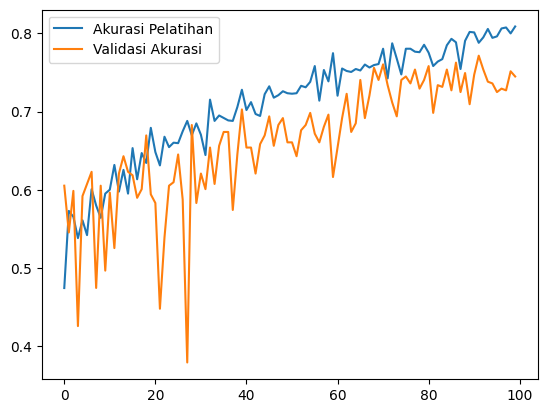

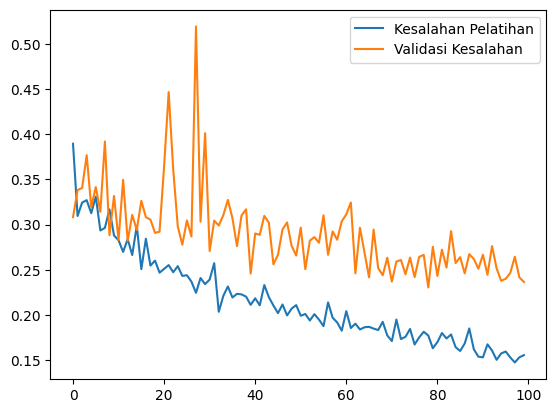

In [ ]:
plt.plot(history.history["accuracy"],label="Akurasi Pelatihan")
plt.plot(history.history["val_accuracy"],label="Validasi Akurasi")
plt.legend()
plt.show()

plt.plot(history.history["loss"],label="Kesalahan Pelatihan")
plt.plot(history.history["val_loss"],label="Validasi Kesalahan")
plt.legend()
plt.show()

**Learning Curves**

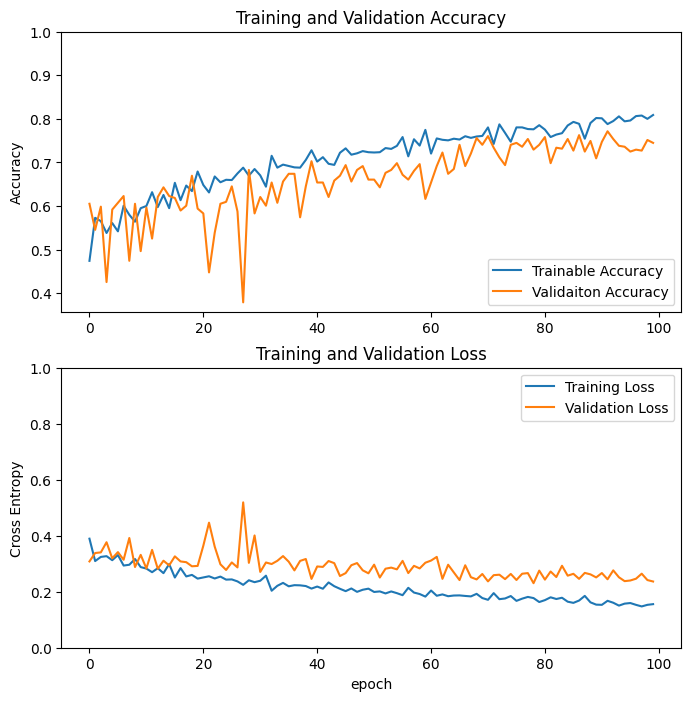

In [ ]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

plt.figure(figsize=(8,8))
plt.subplot(2,1,1)
plt.plot(acc, label='Trainable Accuracy')
plt.plot(val_acc, label='Validaiton Accuracy')
plt.legend(loc='lower right')
plt.ylabel('Accuracy')
plt.ylim([min(plt.ylim()), 1])
plt.title('Training and Validation Accuracy')

plt.subplot(2, 1, 2)
plt.plot(loss, label='Training Loss')
plt.plot(val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.ylabel('Cross Entropy')
plt.ylim([0, 1.0])
plt.title('Training and Validation Loss')
plt.xlabel('epoch')
plt.show()

In [ ]:
import numpy as np
from google.colab import files
from tensorflow.keras.models import load_model
from tensorflow.keras.preprocessing import image

uploaded = files.upload()

for fn in uploaded.keys():
    # Load the image
    img_path = fn
    img = image.load_img(img_path, target_size=(224, 224))
    x = image.img_to_array(img)
    x = np.expand_dims(x, axis=0)
    x = x / 255.0  # Normalize the image

    class_names = ['hdpe', 'ldpe', 'other', 'pet', 'pp', 'ps', 'pvc']

    # Load the model and make predictions
    model = load_model('your_model.h5')
    predictions = model.predict(x)
    predicted_class_index = np.argmax(predictions)
    predicted_class_name = class_names[predicted_class_index]

    print(fn)
    print("Prediksi:", predicted_class_name)

Saving 124153_10-12-2019_16-17-51.jpeg to 124153_10-12-2019_16-17-51.jpeg
1/1 [==============================] - 1s 891ms/step
124153_10-12-2019_16-17-51.jpeg
Prediksi: hdpe


**Konversi Model ke .tflite**

In [ ]:
from tensorflow.keras.applications import MobileNetV2
from tensorflow.keras.layers import Input

input_shape = (224, 224, 3)
input_name = 'mobilenetv2_1_00_224_input'

# Create the input layer with the desired name
input_tensor = Input(shape=input_shape, name=input_name)

# Create the MobileNetV2 model using the modified input layer
model = MobileNetV2(input_tensor=input_tensor, weights='imagenet')

14536120/14536120 [==============================] - 1s 0us/step


In [ ]:
saved_model_dir = '/content/drives/MyDrive/Capstone/data jenis plastik/PlastiCode(1)'
tf.saved_model.save(model, saved_model_dir)

converter = tf.lite.TFLiteConverter.from_saved_model(saved_model_dir)
tflite_model = converter.convert()

with open('PlastiCode-mobilenetv2_1_00_224_input.tflite', 'wb') as f:
  f.write(tflite_model)

In [ ]:
# Untuk Download file tflite
# Load the saved model
model = tf.keras.models.load_model('your_model.h5')  # Ganti dengan nama file model Anda

# Convert the model to TensorFlow Lite format
converter = tf.lite.TFLiteConverter.from_keras_model(model)
tflite_model = converter.convert()

# Save the TensorFlow Lite model
with open('your_model.tflite', 'wb') as f:
    f.write(tflite_model)